# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 8 апреля 2019, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 8 апреля, -4 балла после 06:00 15 апреля, -6 баллов после 06:00 22 апреля  -8 баллов после 06:00 29 апреля.

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

%matplotlib inline
%load_ext pycodestyle_magic
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


Здравствуйте, уважаемые студенты! 

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

# Теоретическое введение



*** Что почитать по теории ***

Одна из лучших книг по ML $-$ "Pattern Recognition and Machine Learning" Bishop, Christopher. 

Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для линейной регрессии.
* Выпишите формулу обновления весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент?

$$ w_{new} = w_{old} - \alpha \nabla_w L $$

$$ \nabla_w L = \frac{1}{N}[\sum_{i}x_i(\langle\,x_i,w\rangle - y_i)] + \frac{2}{C}\sum_{j=1}^D w_j$$ 

$$ w_{new} = w_{old} - \alpha *(\frac{1}{N}[\sum_{i}x_i(\langle\,x_i,w\rangle - y_i)] + \frac{2}{C}\sum_{j=1}^D w_j) $$

Задача 2. Градиент для логистической регрессии.
* Выпишите формулу обновления весов для логистической регрессии с L2 регуляризацией  для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент? Как соотносится этот градиент с градиентом, возникающий в задаче линейной регрессии?

$$ w_{new} = w_{old} - \alpha \nabla_w L $$
$$ a(x_i) =  \sigma( \langle\,x_i,w\rangle ) $$

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}\sum_{j=1}^{D}w_j^2$$

$$ \nabla_w L = -\frac{1}{N}\left[\sum_i\frac{y_i}{a_i}\nabla_w a_i +\frac{y_i-1}{1-a_i}\nabla_w a_i\right] + 2 * \frac{1}{C}\sum_j w_j $$

$$\nabla_w a_i = a_i(1-a_i)x_i^j $$

$$\nabla_w L = -\frac{1}{N}\left[\sum_i(y_i - a_i) * x_i\right] + 2 * \frac{1}{C}\sum_j w_j = \frac{1}{N}\left[\sum_i(a_i - y_i) * x_i\right] + 2 * \frac{1}{C}\sum_j w_j$$

Задача 3. Точное решение линейной регрессии

На лекции было показано, что точное решение линейной регрессии имеет вид $w = (X^TX)^{-1}X^TY $. 
* Покажите, что это действительно является точкой минимума в случае, если матрица X имеет строк не меньше, чем столбцов и имеет полный ранг. Подсказка: посчитайте Гессиан и покажите, что в этом случае он положительно определен. 
* Выпишите точное решение для модели с $L2$ регуляризацией

На лекции было показано, что:

$$\bigtriangledown L(w) = 2X^TXw - 2X^TY$$

В таком случае матрица Гессе будет равна:
$$ H(L) = 2X^TX $$ 

где $2X^TX $ - матрица Грамма признаков. Из этого следует, что матрица Гессе положительно определена и имеет полный ранг. Тогда точнее решение, которое было посчитано на лекции является минимумом.

Точное решение с L2 регуляризацией тогда будет иметь такой вид:
$$ w = (X^TX + \frac{1}{C}I)^{-1}X^TY$$

Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

$$ \frac{\partial E(L|x_i)}{\partial a(x_i)} = -\frac{p(y_i = 1 |x_i )}{a(x_i)} + \frac{p(y_i = 0 | x_i)}{1 - a(x_i)}$$

$$ - \frac{p(y_i = 1 |x_i )}{a(x_i)} + \frac{1 - p(y_i = 1 | x_i)}{1 - a(x_i)} = 0 $$

$$ \frac{-p(y_i = 1 |x_i ) + p(y_i = 1 |x_i )* a(x_i) + a(x_i) - a(x_i) * p(y_i = 1 | x_i)}{(1 - a(x_i)) * {a(x_i)}} = 0 $$

$$ a(x_i)-p(y_i = 1 |x_i ) = 0 $$
$$ a(x_i)=p(y_i = 1 |x_i )  $$

#  Реализация линейной модели (5 баллов)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [6]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [7]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [8]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [9]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [119]:
# %%pycodestyle
def batch_generator(X, y, shuffle=True, batch_size=1):

    mat = np.hstack((X, y.reshape(-1, 1)))
    if shuffle == True:
        np.random.seed(1111)
        np.random.shuffle(mat)
    X_batch = []
    y_batch = []
    for i in range(int(X.shape[0]/batch_size)):
        X_batch = mat[i * batch_size:(i + 1) * batch_size, 0:-1]
        y_batch = mat[i * batch_size:(i + 1) * batch_size, -1]
        yield (X_batch, y_batch)

# a = np.array([[1],[2],[3],[4],[5],[6]])
# b = np.array([0,1,0,1,1,1])
# for x, y in batch_generator(a, b, batch_size=1):
#     print(x, y)
# Теперь можно сделать генератор по данным ()
#  my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1):

In [125]:
# %%pycodestyle
from sklearn.base import BaseEstimator, ClassifierMixin


def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    sigm_value_x = 1 / (1 + np.exp(-x))
    return sigm_value_x


class MySGDClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, batch_generator,
                 C=1, alpha=0.01, max_epoch=10,
                 batch_size=1, model_type='lin_reg'):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """

        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter': [], 'loss': []}
        self.model_type = model_type
        self.batch_size = batch_size

    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """

        n = X_batch.shape[0]
        reg = np.sum(self.weights ** 2) / self.C
        d = np.dot(X_batch, self.weights)
        if self.model_type == 'lin_reg':
            loss = np.sum((d - y_batch) ** 2)
        elif self.model_type == 'log_reg':
            a = sigmoid(d)
            loss = -np.sum(y_batch * np.log(a) + (1 - y_batch) * np.log(1 - a))
        return loss / n + reg

    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        n = X_batch.shape[0]
        reg = 2 * self.weights / self.C
        d = np.dot(X_batch, self.weights)

        if self.model_type == 'lin_reg':
            first = np.dot((d - y_batch), X_batch)
            loss_grad = first * 2
        elif self.model_type == 'log_reg':
            a = sigmoid(d)
            loss_grad = np.dot((a - y_batch), X_batch)
        return loss_grad / n + reg

    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights = self.weights - self.alpha * new_grad
        return

    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        # Нужно инициализровать случайно веса
        X = X.astype(dtype=np.float64)
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        self.weights = np.random.uniform(0, 1, X.shape[1]).astype(np.float64)

        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X, y,
                                                       batch_size=self.batch_size)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_loss = self.calc_loss(X_batch, y_batch)
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                # Подумайте в каком месте стоит посчитать ошибку для отладки модели
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
                self.update_weights(batch_grad)
        return self

    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        X_ = np.c_[np.ones(X.shape[0]), X]
        # Желательно здесь использовать матричные операции между X и весами, например, numpy.dot
        if self.model_type == 'lin_reg':
            y_hat = np.dot(X_, self.weights)
        elif self.model_type == 'log_reg':
            y_hat = sigmoid(np.dot(X_, self.weights))
        return y_hat

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [41]:
def plot_decision_boundary(clf):
    x = np.linspace(-4, 6, num=2)
    plt.plot(x, -(clf.weights[0] + clf.weights[1] * x) / clf.weights[2])

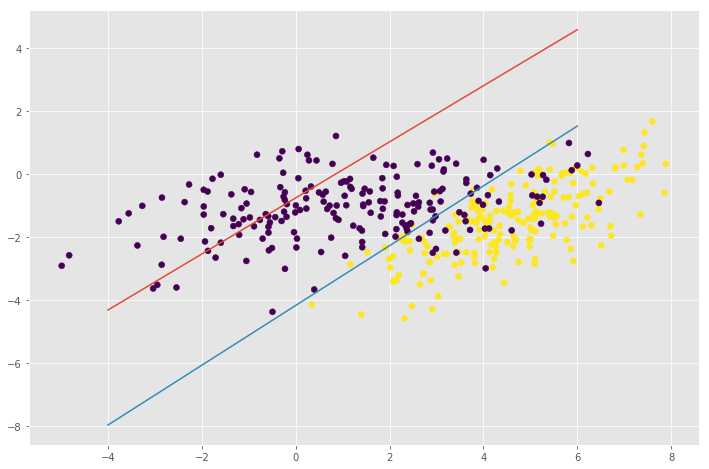

In [45]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

lin_reg = MySGDClassifier(batch_generator, alpha=0.01, max_epoch=500, C=1000, batch_size=16, model_type='lin_reg')
lin_reg.fit(X, y)

plot_decision_boundary(lin_reg)

log_reg = MySGDClassifier(batch_generator, max_epoch=500, C=1000, batch_size=16, model_type='log_reg')
log_reg.fit(X, y)

plot_decision_boundary(log_reg)

plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [46]:
from sklearn.datasets import make_classification

In [55]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)
X = X[:1000]
y = y[:1000]

In [28]:
import warnings
warnings.filterwarnings('ignore')

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

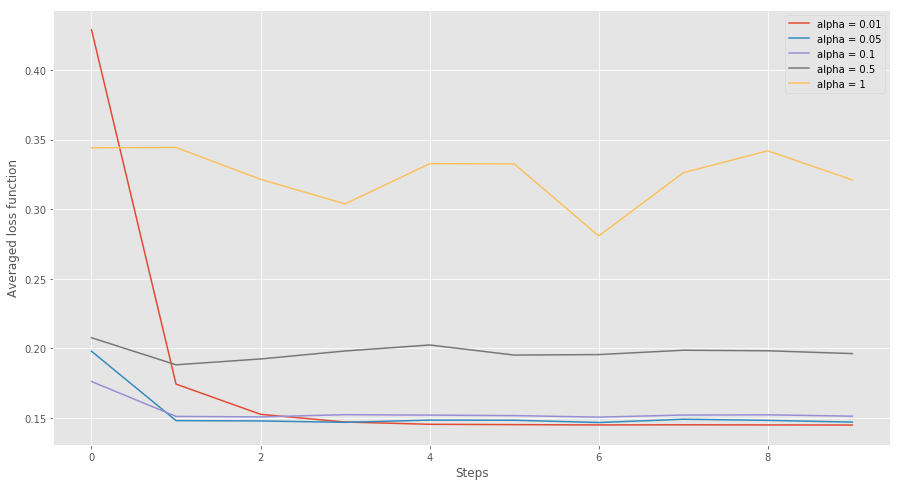

In [56]:
# %%pycodestyle
plt.figure(figsize=(15, 8))

alphas = [ 0.01, 0.05, 0.1, 0.5, 1]
N = 1000

for alpha in alphas:
    log_reg = MySGDClassifier(alpha=alpha, batch_generator=batch_generator,
                              max_epoch=10, C=100,
                              batch_size=1, model_type='log_reg')
    log_reg.fit(X, y)
    steps = len(log_reg.errors_log['loss'])
    losses = []
    for i in range(steps // N):
        loss_sum = np.sum(log_reg.errors_log['loss'][i*N:(i+1)*N])
        losses.append(loss_sum / N)

    plt.plot(np.arange(len(losses)), losses, label='alpha = {}'.format(alpha))

plt.xlabel('Steps')
plt.ylabel('Averaged loss function')
plt.legend()
plt.show()

In [32]:
plt.figure(figsize=(15, 8))

alphas = [0.00001, 0.0001, 0.001, 0.01, 0.05]
N = 1000

for alpha in alphas:
    lin_reg = MySGDClassifier(alpha=alpha, batch_generator=batch_generator,
                              max_epoch=10, C=100,
                              batch_size=1, model_type='lin_reg')
    lin_reg.fit(X, y)
    steps = len(lin_reg.errors_log['loss'])
    losses = []
    for i in range(steps // N):
        loss_sum = np.sum(lin_reg.errors_log['loss'][i*N:(i+1)*N])
        losses.append(loss_sum / N)

    plt.plot(np.arange(len(losses)), losses, label='alpha = {}'.format(alpha))

plt.xlabel('Steps')
plt.ylabel('Averaged loss function')
plt.legend()
plt.show()

KeyboardInterrupt: 

<Figure size 1080x576 with 0 Axes>

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

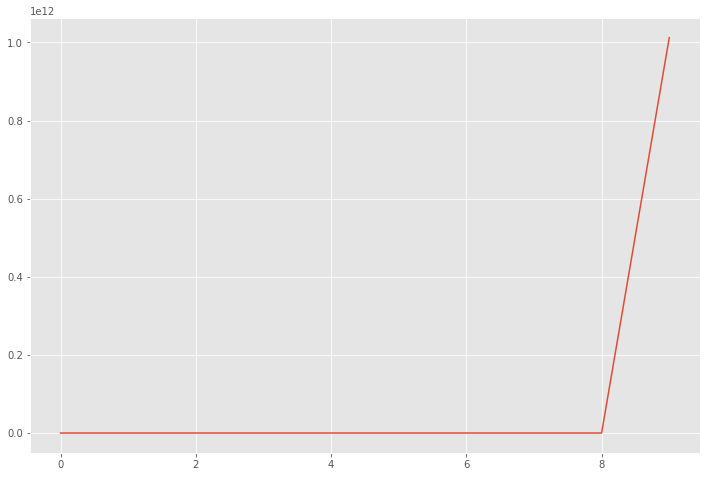

In [57]:
C = np.logspace(3, -3, 10)
res = []
for c in C:
    log_reg = MySGDClassifier(batch_generator=batch_generator, max_epoch=1, 
                              C=c, alpha=0.01, batch_size=100, model_type='log_reg')
    log_reg.fit(X, y)
    res.append(np.mean(log_reg.weights))

plt.plot(range(len(res)), res)
plt.show()

In [ ]:
C = np.logspace(3, -3, 10)
res = []
for c in C:
    lin_reg = MySGDClassifier(batch_generator=batch_generator, max_epoch=1, 
                              C=c, alpha=0.01, batch_size=100, model_type='lin_reg')
    lin_reg.fit(X, y)
    res.append(np.mean(lin_reg.weights))

plt.plot(range(len(res)), res)
plt.show()

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

# Боевое применение (3  балла)

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в project_overview-2.ipynb

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [58]:
doc_to_title = {}
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print (len(doc_to_title))


28026


In [59]:
import pandas as pd
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [60]:
import numpy as np
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_train.append(sorted(all_dist, reverse=True)[0:15]    )
X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print (X_train.shape, y_train.shape, groups_train.shape)

(11690, 15) (11690,) (11690,)


In [36]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [61]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [62]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [63]:
model = MySGDClassifier(batch_generator, C=1, alpha=0.01, max_epoch=100, model_type='log_reg', batch_size=1)
model.fit(X_train, y_train)
f1_score(y_train, (model.predict(X_train) > 0.5).astype(int))

KeyboardInterrupt: 

In [44]:
model = MySGDClassifier(batch_generator, C=1, alpha=0.01, max_epoch=100, model_type='log_reg', batch_size=10)
model.fit(X_train, y_train)
f1_score(y_train, (model.predict(X_train) > 0.5).astype(int))

0.6159790258037808

In [47]:
model = MySGDClassifier(batch_generator, C=1, alpha=0.01, max_epoch=100, model_type='log_reg', batch_size=100)
model.fit(X_train, y_train)
f1_score(y_train, (model.predict(X_train) > 0.5).astype(int))

0.6148302148302148

Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

In [ ]:
# def validation(X, y, groups_train):
#     valid_group_size = 0.4
#     np.random.seed(42)
#     groups = np.unique(groups_train)
#     np.random.shuffle(groups) 
#     count = groups.shape[0] 
#     valid_groups = groups[:int(count*valid_group_size)]
#     valid_mask = np.isin(groups_train, valid_groups)
#     train_mask = np.logical_not(valid_mask)
#     return X[train_mask], X[valid_mask], y[train_mask], y[valid_mask]

def validation(X, y, groups_train):
    #validatoin
    np.random.seed(22)

    n = np.unique(groups_train).shape[0]
    k = n // 5
    p = np.arange(1, n + 1)
    np.random.shuffle(p)
    mask_train = list(np.any(i in p[:k] for i in groups_train))
    mask_valid = list(np.any(i in p[k:] for i in groups_train))
    return X_train[mask_train], X_train[mask_valid], y_train[mask_train], y_train[mask_valid]
#     X_Train = X_train[mask_train]
#     y_Train = y_train[mask_train]
#     X_Valid = X_train[mask_valid]
#     y_Valid = y_train[mask_valid]

In [ ]:
Train_x, Validation_x, Train_y, Validation_y = validation(X_train, y_train, groups_train)
print(Train_x.shape, Validation_x.shape)

In [32]:
np.random.seed(22)

n = np.unique(groups_train).shape[0]
k = n // 5
p = np.arange(1, n + 1)
np.random.shuffle(p)
mask_train = list(np.any(i in p[:k] for i in groups_train))
mask_valid = list(np.any(i in p[k:] for i in groups_train))
X_Train = X_train[mask_train]
y_Train = y_train[mask_train]
X_Valid = X_train[mask_valid]
y_Valid = y_train[mask_valid]

parameters = [
    {
     'batch_generator': [batch_generator],
     'C': np.linspace(1, 20, 20),
     'alpha': [0.1],
     'max_epoch': np.linspace(10, 200, 20).astype(int),
     'model_type': ['log_reg'],
     'batch_size':[4000]
    }
]
g = ParameterGrid(parameters)

best_score = 0
best_param = []
for param in g:
    my_clf = MySGDClassifier(**param)
    my_clf.fit(X_Train, y_Train)
    score = f1_score(y_Valid, my_clf.predict(X_Valid) > 0.5)
    if score > best_score:
        best_score = score
        best_param = [param]

print(best_param, best_score)

/home/oleg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log


[{'C': 6.0, 'alpha': 0.1, 'batch_generator': <function batch_generator at 0x7f1de4700c80>, 'batch_size': 4000, 'max_epoch': 10, 'model_type': 'log_reg'}] 0.6363500373971579


In [15]:
import itertools
from sklearn.model_selection import ParameterGrid
best_model={}
max_score = 0

C = [1, 10, 100, 1000, 0.01]
alpha = [0.001, 0.01, 0.1, 0.5]
epoch = [10, 50, 100]
param = itertools.product(C, alpha, epoch)

for (c, a, epoch) in param:
    clf = MySGDClassifier(batch_generator,
                            model_type='log_reg', alpha=a,
                            max_epoch=epoch, C=c, batch_size=10)
    clf.fit(Train_x, Train_y)
    y_pred = clf.predict(Validation_x)
    f1 = f1_score(Validation_y, (y_pred > 0.5).astype(int))
    if(f1 > max_score):
        max_score = f1
        best_model['max_score'] = f1
        best_model['alpha'] = a
        best_model['C'] = c
        best_model['max_epoch'] = epoch

/home/oleg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log
/home/oleg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in multiply
/home/oleg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in double_scalars
/home/oleg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in square
/home/oleg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: overflow encountered in true_divide
/home/oleg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/home/oleg/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [16]:
print(best_model)

{'max_score': 0.6346851302340917, 'alpha': 0.001, 'C': 0.01, 'max_epoch': 10}


In [88]:
test_data = pd.read_csv('test_groups.csv')
testgroups_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    title = doc_to_title[doc_id]
    if doc_group not in testgroups_titledata:
        testgroups_titledata[doc_group] = []
    testgroups_titledata[doc_group].append((doc_id, title))

X_test = []
groups_test = []
for new_group in testgroups_titledata:
    docs = testgroups_titledata[new_group]
    for k, (doc_id, title) in enumerate(docs):

        groups_test.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_test.append(sorted(all_dist, reverse=True)[0:15])

X_test = np.array(X_test)
groups_test = np.array(groups_test)
print(X_test.shape, groups_test.shape)

(16627, 15) (16627,)


In [106]:
X_test = scaler.transform(X_test)

In [130]:


clf = MySGDClassifier(batch_generator, model_type='log_reg',
                        alpha=0.01,
                        max_epoch=100, C=5, batch_size=4000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(y_pred)
y_pred = (clf.predict(X_test) > 0.5).astype(int)
print(y_pred[y_pred == 0].shape)
print(y_pred[y_pred == 1].shape)

# submit = pd.DataFrame({'pair_id': test_data['pair_id'], 'target': y_pred})
# submit.to_csv("submission.csv", index=False)

[0.38363836 0.51047322 0.67876291 ... 0.64222677 0.50943962 0.98975265]
(11488,)
(5139,)


In [12]:
'''
Напишем кросс-валидацию по группам.
Не должно быть пересечений в группам в train и validate.
'''
def myGroupKfold(X, groups_train, n_splits=5, random_state=None):
    
    # set seed
    np.random.seed(random_state)
    
    groups = np.unique(groups_train)
    step = groups.shape[0] // n_splits
    ost = groups.shape[0] % n_splits
    np.random.shuffle(groups)
    
    # delete seed
    np.random.seed(None)
    
    index = np.arange(groups.shape[0])
    
    for i in range(n_splits):
        if i < ost:
            test_groups = groups[i*step:(i+1)*step+1]
        else:
            test_groups = groups[i*step:(i+1)*step]
        test_mask = np.isin(groups_train, test_groups)
        train_mask = np.logical_not(test_mask)
        yield (train_mask, test_mask)

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
import itertools
from operator import setitem


f1={}

C_grid = [0.1, 0.5, 0.8, 1, 2, 5, 10]
alpha_grid = [0.005, 0.01, 0.1]
epoch_grid = [2, 5, 10, 20]
model_grid = ['lin_reg', 'log_reg']

cnt = len(model_grid) * len(C_grid) * len(alpha_grid) * len(epoch_grid)
step = cnt / 40
marg = step
print("   ["+' '*16+'Progress'+' '*16+']')

group_kfold = myGroupKfold(X_train, groups_train, n_splits=10, random_state=0)

for k, (train_mask, test_mask) in enumerate(group_kfold):
    train, valid = X_train[train_mask], X_train[test_mask]
    train_y, valid_y = y_train[train_mask], y_train[test_mask]
        
    scr = StandardScaler()
    train = scr.fit_transform(train)
    valid = scr.transform(valid)

    param_grid = itertools.product(model_grid, C_grid, alpha_grid, epoch_grid)
    
    print(str(k)+') [=',end='')
    marg = step
    
    th = (1 - train_y.mean()) * 100
    
    for j, (model_type, C, alpha, max_epoch) in enumerate(param_grid):
        
        model = MySGDClassifier(batch_generator, C=C, alpha=alpha, max_epoch=max_epoch,
                                batch_size=-1, model_type=model_type)
        model.fit(train, train_y)
        
        y_pred = model.predict(valid)
        y_pred = y_pred >= np.percentile(y_pred, th)
        
        param = {'model_type': model_type, 'C': C, 'alpha': alpha, 'max_epoch': max_epoch}
        
        if str(param) not in f1:
            f1[str(param)] = []
        
        f1[str(param)] += [f1_score(valid_y, y_pred)]
        
        if j > marg:
            marg += step
            print('=', end='')
            
    print(']')

list(map(lambda x: setitem(f1, x, sum(f1[x]) / len(f1[x])), f1))

max_key = max(f1, key=f1.get)
print('\nMax f1_score: ', f1[max_key])
print('Params: ', max_key)

   [                Progress                ]
0) [========================================]
1) [========================================]
2) [========================================]
3) [========================================]
4) [========================================]
5) [========================================]
6) [========================================]
7) [========================================]
8) [========================================]
9) [========================================]

Max f1_score:  0.5935792424669126
Params:  {'model_type': 'log_reg', 'C': 0.1, 'alpha': 0.005, 'max_epoch': 2}


С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна. Если да, то Вы молодец!

# Контрольные вопросы
Постарайтесь максимально развернуто и честно ответить на вопросы. Они охватывают тему линейных моделей и скорее нужны преподавателям, чтобы понимать, что именно Вы усвоили плохо. Надеюсь, они подскажут, что именно в теме Вы не понимаете или наоборот порадают, что Вы все знаете ^_^

* Опишите основные, на Ваш взгляд,  отличия логистической регрессии от линейной регрессии. Почему, на ваш взгляд, задачу классификации решают логистической, а не линейной регрессией?

Линейная регрессия выдает некоторое числовое значение(неограниченную велечину). Логистическая, блягодаря сигмоида, можно рассматривать, как вероятность принадлежности к обьекту.

* Как Вы думаете, для каких типов задач (объем данных, число признаков, типы признаков) стоит отдавать предпочтение линейным моделям?

Те задачи, в которых признаки независимы друг от друга. Линейные модели плохо работают с категориальными признаками. На обьемы данных, как я понимаю не так важны в этой модели.

* Пусть на обучении мы имеем выборку размера $N$, число признаков $D$. Чему равна алгоритмическая сложность одного шага градиентного спуска? Cтохастического градиентного спуска?  Сложность предсказания на одном объекте?

Градиентный спуск: O(N*D)

стохастический спуска: O(n*D), n- размер батча

сложность предсказания: O(D)

* В чем преимущества стохастического градиентного спуска (в том числе мини-батч) над обычным градиентным спуском? В чем его недостатки? Рассмотрите несколько аспектов $-$ скорость сходимости, необходимость загрузки всех данных в оперативную память, сложность вычисления одного шага.

Преимущества:

    Нет необходимости загружать все данные в оперативную память
    
    Легче вычислять каждый шаг
    
    Быстрее вычисляется
    
Недостатки:

    Медленнее сходиться
    
    Градиентный спуск считается только по части выборки и поэтому шаг будет осуществляться с некоторыми отклонениями. 

* Как Вы думаете, при обучении линейной модели с помощью SGD, ошибку на новом объекте стоит считать до итерации спуска на этом объекте или после? Почему Вы так думаете? Возможно, Вам будет интересно ознакомиться с http://hunch.net/~jl/projects/prediction_bounds/thesis/mathml/thesisse44.xml

До итерации, потому что мы смотрим ошибку на еще не обновленных весах

* Как Вы думаете, во времена такого бума нейронных сетей, остаются ли популярными линейные модели, или это уже пережиток прошлого? Почему Вы так думаете?

Линейные модели проще и они легче интерпретируются. Их можно быстрее обучать и мне кажется они всегда будут оставаться базовыми моделями.

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

Не совсем понятна была роль коефициента регуляризации. При больших С получается практически невелируем регуляризацию.

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***